# This file works with FILAMENT ERUPTION and 2012 to 2013 Track information 

In [2]:
#all imports 
from sunpy.net import hek
from sunpy.net import hek2vso
import matplotlib.pyplot as plt
%matplotlib inline
import shapely
from shapely.wkt import dumps, loads
import numpy as np
import pandas as pd
from shapely.geometry.polygon import LinearRing, Polygon
from datetime import timedelta
import datetime
from sunpy.time import *
from dateutil.parser import parse
import matplotlib.cm as cm
import matplotlib as mpl
from operator import itemgetter
from itertools import groupby
import itertools
import operator
from datetime import timedelta
import csv
import time

In [3]:
client = hek.HEKClient()
h2v = hek2vso.H2VClient()
tstart = '2012/01/01 00:00:00'
tend = '2013/12/31 23:59:59'
event_type = 'FE'
eruptions = client.query(hek.attrs.Time(tstart,tend),hek.attrs.EventType(event_type))
vso_records = h2v.translate_and_query(eruptions[10])



In [4]:
##filters the eruptions so the data is unique
times=[elem["event_starttime"] for elem in eruptions] 
result=[]
indices=[]
### the following loop will remove identical eruptions that have been recorded at different wavelengths by sorting with time
for element in times:
    if element not in result:
        indices.append((times.index(element)))
        result.append(element)
filtered=[eruptions[i] for i in indices] #creates a filtered list of objects that are not indentical

# The following kernel reads in the tracking document, groups the data by track number, and adds  "null" data for all tracks that have less than three entries. 

In [5]:
fi_tracked = pd.read_csv('FIDustinTracked24Mo.txt',delimiter='\t')
fi_tracked.head()
tracks=fi_tracked['Track No.']
good_tracks = fi_tracked.groupby('Track No.').filter(lambda x: len(x['Track No.']) >= 3, dropna=False) 

# The following kernel looks at both "good tracks" (tracks with 3 or more elements) and "filtered" eruption data (data that does not occur at multiple wavelengths). The code loops through the list of filtered eruptions and checks if any eruption is contained inside a good track (also iterated through with a loop). 

In [6]:
margin = datetime.timedelta(hours=12)             
FT_time = good_tracks['HEK_time']    #Finds the time stamps for all the filaments
FE_time = [elem["event_starttime"] for elem in filtered] #Finds the time stamps for all the eruptions
FT_poly = good_tracks['HPC_BB_Poly']    #Finds the polygon coordinates for the good_tracks
FE_coords = [elem["hpc_coord"] for elem in filtered] #Finds the point coordinates for the filtered eruptions 
contained=[]    ####This will be a helpful list for finding which tracks have eruptions contained inthem 
loopnumb=[]    #to keep track of the eruption number 
practice=[]
for j in range(0, len(FE_coords)):    #looks at all possible eruptions 
    FET=(parse_time(FE_time[j])) 
    FE_point_obj = loads(FE_coords[j]) #creates a shapely point object
    for i in range(0, len(FT_poly)):  #looks at all possible tracks 
        if pd.isnull(FT_poly[i]):   #skips over tracks of less than 3 elements 
            pass
        else:   
            FLT=parse(FT_time[i]) 
            FT_poly_obj = loads(FT_poly[i])   #creates polygon object from track
            if FT_poly_obj.contains(FE_point_obj) and FET-margin <= FLT <= FET + margin: #checks if point is contained in polygon 
                contained.append(good_tracks['Track No.'][i])   #finds the track number of these tracks 
                loopnumb.append(j)
                print FE_time[j]
                if good_tracks['Track No.'][i] == 16.0:
                    practice.append((FE_time[j], good_tracks['Track No.'][i]))
                print "This means that the eruption point is contained in the filament polygon"
                print j,i  #the indicies of the eruption and filament track
erup=[indices[i] for i in loopnumb]   #getting the eruption index from a list of possible indices
filtered2=[eruptions[i] for i in erup]   #eruption data that correspond to being contained in a filament 
print erup

2012-02-10T15:24:04
This means that the eruption point is contained in the filament polygon
28 766
2012-06-08T13:40:04
This means that the eruption point is contained in the filament polygon
122 3392
2012-07-11T07:30:04
This means that the eruption point is contained in the filament polygon
144 4479
2013-01-08T16:36:03
This means that the eruption point is contained in the filament polygon
241 8758
2013-08-16T18:00:03
This means that the eruption point is contained in the filament polygon
397 12551
2013-10-02T23:10:03
This means that the eruption point is contained in the filament polygon
440 13436
2013-10-18T00:00:03
This means that the eruption point is contained in the filament polygon
448 13707
[71, 334, 372, 616, 969, 1109, 1136]


In [7]:
good_polygons=[] #Trying to find polygon data for the filaments that contained eruptions and at a good time 
for i in range(len(good_tracks)): #iterating through the whole list of tracks 
    if good_tracks['Track No.'][i] in contained:  #if the track number is in the lists created previously 
         good_polygons.append((good_tracks['Track No.'][i],good_tracks['HPC_BB_Poly'][i]))#append the polygon data to good polygons

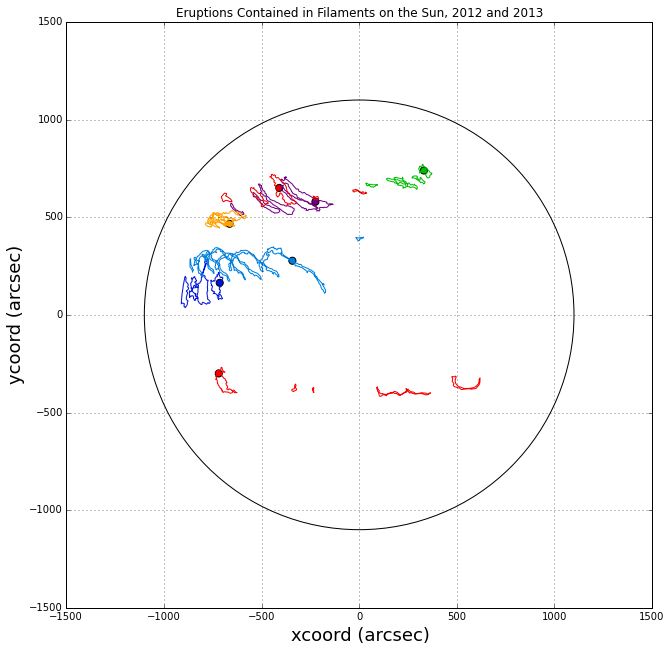

In [8]:
####makes a colorscale for the eruptions
colorscale=[]
norm = mpl.colors.Normalize(vmin=0, vmax=6700)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
for item in contained: #plotting those filaments that have eruptions contained within them
    scale1= m.to_rgba(item) 
    colorscale.append(scale1)

####plots eruptions/sun 
plt.grid(True)
plt.ylabel('ycoord (arcsec)',fontsize=18)
plt.xlabel('xcoord (arcsec)',fontsize=18)
plt.axis([-1500, 1500, -1500, 1500])
longitude = [elem["hpc_x"]for elem in filtered2]
latitude = [elem["hpc_y"] for elem in filtered2]
fig=plt.scatter(longitude,latitude,c= colorscale,s=50)
Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
plt.gcf().gca().add_artist(Sun)
plt.title('Eruptions Contained in Filaments on the Sun, 2012 and 2013')
fig1 = plt.gcf()
fig1.set_size_inches(10.5,10.5)
ax = fig1.add_subplot(111)
ax.set_aspect('equal') 

####plots filament tracks 
for poly in good_polygons: 
    scale=m.to_rgba(poly[0])
    plot_polygon=plt.Polygon(loads(poly[1]).exterior,color=scale,linewidth=1,fill=None)
    fig1.gca().add_artist(plot_polygon)
plt.show()

# The following kernel looks at both "good tracks" (tracks with 3 or more elements) and "filtered" eruption data (data that does not occur at multiple wavelengths). The code loops through the list of filtered eruptions and checks if any eruption box intersects with a good track (also iterated through with a loop).

In [9]:
margin = datetime.timedelta(hours=12)             
FT_time = good_tracks['HEK_time']    #Finds the time stamps for all the filaments
FE_time = [elem["event_starttime"] for elem in filtered] #Finds the time stamps for all the eruptions
FT_poly = good_tracks['HPC_BB_Poly'] 
FE_box = [elem["hpc_bbox"] for elem in filtered] 
FE_coords = [elem["hpc_coord"] for elem in filtered]
intersected=[] #the tracks that intersect with eruption boxes
event=[]  #eruption point 
manypoly=[] #center point of filament
erupno=[]   #eruption's number 
time_erup=[]
start = time.time()
########## to only plot certain eruptions
for j in range(0, len(FE_box)):    #looks at all possible eruptions 
    FET=(parse_time(FE_time[j]))
    FE_box_obj = loads(FE_box[j]) #creates a shapely box object object
    FE_point_obj=loads(FE_coords[j])
    for i in range(0, len(FT_poly)):  #looks at all possible tracks 
        if pd.isnull(FT_poly[i]):   #skips over tracks of less than 3 elements 
            pass
        else:    
            FLT=parse(FT_time[i])
            FT_poly_obj = loads(FT_poly[i])   #creates polygon object from track
            if FT_poly_obj.intersects(FE_box_obj) and FET-margin <= FLT <= FET + margin: #checks if box intersects with polygon
                intersected.append(good_tracks['Track No.'][i])   #finds the track number of these tracks 
                #print "This means that the eruption bounding box intersects with the filament polygon"
                manypoly.append(loads(good_tracks['HPC_Center'][i]))  #grabs the center point coords of the filament 
                event.append(FE_point_obj)      #grabs the eruption point 
                erupno.append(j)
                time_erup.append(FET)
totaltime = start - time.time()
print 'This loop took', totaltime%60
multi=zip(intersected, event, manypoly, erupno, time_erup) #creates a list of tuples of [(track no, eruption polygon point, filament polygon point, iteration).

This loop took 27.445854187


In [19]:
dist=[]  ###will be a list of distances between the eruptions and center of the filaments 
final_erup=[]   #eruption's number
practice=[]
for item in multi:
     dist.append(item[1].distance(item[2]))

multi3=zip(intersected, event, dist, erupno, time_erup) #This is what you did
test = pd.DataFrame(multi3) #Turn multi3 into a pandas dataframe
columns=['Track No.','Eruption Coord','Distance to filament','Eruption No.', 'Eruption Time'] #Name the columns so they are easier to deal with
test.columns=columns
idx = test.groupby(['Track No.'])['Distance to filament'].transform(min) == test['Distance to filament']
idx2 = test.groupby(['Eruption No.'])['Distance to filament'].transform(min) == test['Distance to filament']
only_min=test[idx & idx2]
only_min = only_min.sort('Track No.')
close=[]   #those tracks closest to the eruptions 
corresponding=[] ### just to know which tracks correspond to which eruption 
for index, item in only_min.iterrows():
    close.append(item[0])   #for the tracks 
    final_erup.append(item[3])   #for the eruptions 
    corresponding.append((item[0], item[3]))   # to see which tracks correspond to which eruptions
    practice.append((item[4], item[0]))
#print corresponding    
    
erupbox_with_track=[indices[i] for i in final_erup]
filtered3=[eruptions[i] for i in erupbox_with_track]

print len(only_min)

172


In [20]:
okay_polygons=[] #Trying to find polygon data for the filaments that intersect with eruption box
for i in range(len(good_tracks)): #iterating through the whole list of tracks 
    #if good_tracks['Track No.'][i] in intersected and good_tracks['Track No.'][i] in okay_filaments:   #if the track number is in the list created previously 
    if good_tracks['Track No.'][i] in close: 
            okay_polygons.append((good_tracks['Track No.'][i],good_tracks['HPC_BB_Poly'][i])) #append the polygon data to good polygons

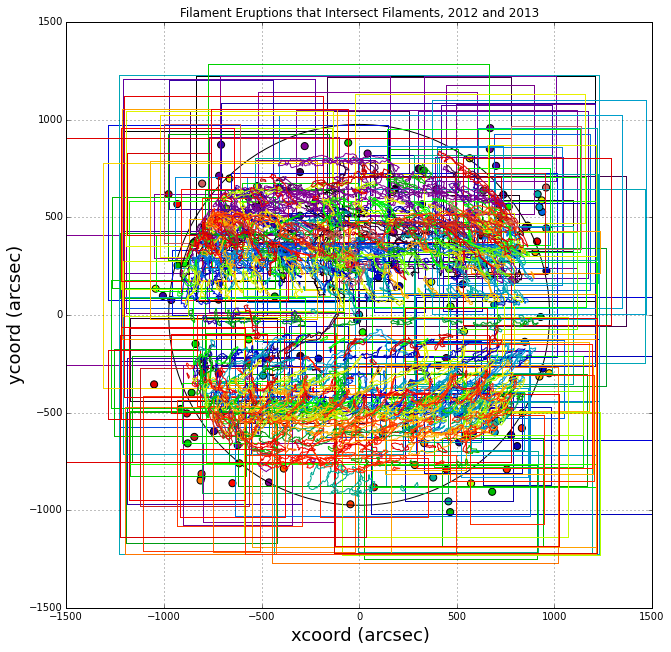

In [21]:
####makes a colorscale for eruptions 
colorscale2=[]
norm = mpl.colors.Normalize(vmin=0, vmax=6700)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
for item in close: #plotting those filaments that have eruptions contained within them
    scaleR= m.to_rgba(item) 
    colorscale2.append(scaleR)
    
####plots eruptions/sun
plt.grid(True)
plt.ylabel('ycoord (arcsec)',fontsize=18)
plt.xlabel('xcoord (arcsec)',fontsize=18)
plt.axis([-1500, 1500, -1500, 1500])
longitude = [elem["hpc_x"]for elem in filtered3]
latitude = [elem["hpc_y"] for elem in filtered3]
fig=plt.scatter(longitude,latitude,c= colorscale2,s=50)
Sun=plt.Circle((0,0), radius=975, color='black', fill=False)
plt.gcf().gca().add_artist(Sun)
plt.title('Filament Eruptions that Intersect Filaments, 2012 and 2013')
fig1 = plt.gcf()
fig1.set_size_inches(10.5,10.5)
ax = fig1.add_subplot(111)
ax.set_aspect('equal')

####plots eruption boxes 
box = [elem["hpc_bbox"] for elem in filtered3]    #plotting only those eruptions boxes that intersect with filaments
boxinfo=zip(box, close)
for item in boxinfo:
        scaleR= m.to_rgba(item[1])
        plot_box=plt.Polygon(loads(item[0]).exterior,color=scaleR,linewidth=1,fill=None)
        fig1.gca().add_artist(plot_box)
        
###plots filament tracks         
for poly in okay_polygons: #plotting those filaments that intersect the bounding box of eruptions
    scale2=m.to_rgba(poly[0])
    plot_polygon=plt.Polygon(loads(poly[1]).exterior,color=scale2,linewidth=1,fill=None)
    fig1.gca().add_artist(plot_polygon)
plt.show()

In [ ]:
   ###new updated eruption list for each track 
erupting_tracks =[]
tot=[]
unique=[]
erupind=[]
close_unique=np.unique(close)
for tracks in close_unique:
    tot.append(unique)
    unique=[]
    for i in range(0, len(good_tracks)):
        if tracks == good_tracks['Track No.'][i]:
            unique.append(i)
            
for item in tot:
    colorscale2=[]
    norm = mpl.colors.Normalize(vmin=0, vmax=6700)
    cmap = plt.get_cmap('nipy_spectral')
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for thing1 in close: #plotting those filaments that have eruptions contained within them
        scaleR= m.to_rgba(thing1) 
        colorscale2.append(scaleR)
####plots eruptions/sun
    plt.grid(True)
    plt.ylabel('ycoord (arcsec)',fontsize=18)
    plt.xlabel('xcoord (arcsec)',fontsize=18)
    plt.axis([-1500, 1500, -1500, 1500])
    fig1 = plt.gcf()
    Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
    plt.gcf().gca().add_artist(Sun)
    fig1.set_size_inches(10.5,10.5)
    ax = fig1.add_subplot(111)
    ax.set_aspect('equal')
        ##############################
    for i in range(0, len(item)):
        j=item[i]
        trnum=  good_tracks['Track No.'][j]
        stime=  good_tracks['HEK_time'][j]
        print stime
        if i == 0:
            first_poly = loads(good_tracks['HPC_Center'][j])
        for thing1 in corresponding:
            if thing1[0] == trnum:
                erupind.append(thing1[1])
        verup=[indices[i] for i in erupind]   #getting the eruption index from a list of possible indices
        erupind=[]
        filtered4=[eruptions[k] for k in verup]
        longitude = [elem["hpc_x"]for elem in filtered4]
        latitude = [elem["hpc_y"] for elem in filtered4]
        erup_coord = [elem["hpc_coord"] for elem in filtered4]
        erup_t = [elem["event_starttime"] for elem in filtered4]
        for thing2 in erup_t:
            tim = (parse_time(thing2))
        for thing3 in erup_coord:
            erup_point = loads(thing3)
        if erup_point.x < first_poly.x:  #finding if the eruption occurs before the first polygon
            plt.close()
        else:
            if abs(erup_point.y - first_poly.y) > 300:
                plt.close()
            else:
                erupting_tracks.append(trnum)
                plt.text(1400,1400,str(erup_t))
                fig=plt.scatter(longitude,latitude, c = 'grey',s=50)
                scale2=m.to_rgba(good_tracks['Track No.'][j])
                plot_polygon=plt.Polygon(loads(good_tracks['HPC_BB_Poly'][j]).exterior,color=scale2,linewidth=1,fill=None)
                fig1.gca().add_artist(plot_polygon)
                plt.title('Track Number %(Trackno)d at %(starttime)s on the Sun.' % {"Trackno" : trnum, "starttime": stime})
    plt.show()
erupting_tracks= np.unique(erupting_tracks)